In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import os

import librosa as l
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn

# Keras
import keras
import keras_metrics
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop

In [2]:
#%pip install keras_metrics

In [3]:
final_df = pd.read_csv('../Datasets/final_df.csv')

# drop first column
final_df.drop('Unnamed: 0', axis='columns', inplace=True)

# train-test split dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

final_df_testing = final_df.copy()
final_df_testing = shuffle(final_df_testing)

X = final_df_testing.drop(columns=['Path', 'Emotions_without_gender','Emotions_with_gender'], axis=1)
y = final_df_testing['Emotions_with_gender']
print(X.shape, y.shape)

(11682, 173) (11682,)


In [4]:
# Handle imbalance classes with SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

print('Original dataset shape', Counter(y))
print('\n')
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({4: 1096, 3: 1096, 2: 1096, 0: 1096, 6: 1096, 5: 960, 11: 767, 14: 767, 12: 767, 8: 767, 10: 767, 13: 623, 7: 496, 15: 96, 1: 96, 9: 96})


Resample dataset shape Counter({4: 1096, 11: 1096, 5: 1096, 13: 1096, 14: 1096, 3: 1096, 12: 1096, 2: 1096, 0: 1096, 6: 1096, 7: 1096, 8: 1096, 15: 1096, 10: 1096, 1: 1096, 9: 1096})


In [5]:
X_train

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MEL124,MEL125,MEL126,MEL127,TONZ0,TONZ1,TONZ2,TONZ3,TONZ4,TONZ5
4216,-338.726600,132.259230,-8.114789,44.194748,-7.917725,5.655036,-16.220108,7.988503,-5.889780,-2.510620,...,1.855967e-09,1.821787e-09,1.799821e-09,1.786188e-09,-0.021398,0.026012,-0.052059,-0.014372,0.015607,0.012016
13474,-224.224270,106.801533,-12.256560,31.565567,-14.800180,1.741204,-15.016735,3.655717,-15.223540,-3.022801,...,1.101164e-09,1.082948e-09,1.071794e-09,1.064177e-09,0.030595,-0.011121,-0.071824,-0.018892,0.021980,0.015564
2344,-337.757930,131.389590,-9.936127,43.260136,-19.462640,16.564735,-16.320042,3.028381,-18.212278,5.929302,...,3.222259e-09,3.165103e-09,3.128746e-09,3.106246e-09,0.008800,0.013255,-0.006334,-0.088177,0.030838,-0.004927
15889,-390.172429,115.434024,18.902423,59.796405,-7.427457,29.949829,-15.976765,3.029861,-14.858413,1.081516,...,1.558121e-09,1.520412e-09,1.495795e-09,1.480745e-09,-0.010442,-0.010877,-0.040083,-0.009870,0.016209,-0.000075
15538,-473.379184,143.256086,15.519629,55.403039,-5.313901,38.817960,-21.261964,13.492870,-8.602654,3.394539,...,2.684789e-09,2.639708e-09,2.610931e-09,2.592981e-09,-0.011425,-0.019142,-0.054848,-0.015635,0.009444,0.004817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-446.802830,90.487470,30.075110,-8.851059,-2.027134,-0.060457,-7.934279,-0.361000,-16.530842,-11.638746,...,3.412247e-04,2.770132e-04,1.062683e-04,8.342354e-06,-0.027959,0.029184,-0.004216,-0.061707,0.000849,-0.002038
11964,-785.818611,36.691527,3.588954,8.546596,-2.603047,-4.069743,-6.521536,-8.908616,-4.449089,-5.067684,...,1.745136e-05,2.131074e-05,1.077967e-05,1.231630e-06,-0.014947,0.014218,0.005271,-0.034132,0.004307,-0.001919
5390,-700.952150,53.937096,2.643323,5.049772,5.199825,-2.861731,-3.831619,-6.806163,-10.532740,-3.214916,...,1.334244e-05,1.766137e-05,2.349727e-05,2.183121e-06,0.051231,-0.009925,-0.005487,0.031132,0.023328,-0.010939
860,-389.829860,43.379204,-10.333385,-3.004936,-4.731334,16.283024,-21.866278,-18.415382,-19.517900,-5.504111,...,3.729904e-04,4.370317e-04,2.707302e-04,2.189599e-05,-0.035797,-0.028414,0.043949,-0.090041,-0.001986,-0.031123


In [6]:
#X_smote.shape[1], 1
X_smote.shape[1], 1

(173, 1)

In [7]:
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, kernel_size=5, strides=1, # first convulational layer
                        padding="same", activation="relu",
                        input_shape=(X_smote.shape[1], 1))) 
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=5, strides=1,  # second convulational layer
                        padding="same", activation="relu"))
#model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten()) # flatten into a 1D array
model.add(layers.Dense(128, activation='relu')) # fully connected layer
model.add(layers.Dense(64, activation='relu')) # fully connected layer

model.add(layers.Dense(16, activation="softmax")) # output layer

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 173, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 173, 64)           41024     
                                                                 
 flatten (Flatten)           (None, 11072)             0         
                                                                 
 dense (Dense)               (None, 128)               1417344   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
Total params: 1468432 (5.60 MB)
Trainable params: 14684

## We use the same model that we used for the Non-augmented dataset. We will also be using 41 epochs to train the model.

In [8]:
# Compile the model with appropriate Loss function
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)

#sparse_categorical_crossentropy --> when targets are integer & suitable for multiclasses
#categorical_crossentropy --> when targets are one-hot encoded vectors (binary) 

epochs = 41
 
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test,y_test)) 

Epoch 1/41

439/439 [==============================] - 19s 42ms/step - loss: 1.8775 - accuracy: 0.4044 - val_loss: 1.5581 - val_accuracy: 0.4932
Epoch 2/41
439/439 [==============================] - 18s 41ms/step - loss: 1.3918 - accuracy: 0.5471 - val_loss: 1.3079 - val_accuracy: 0.5747
Epoch 3/41
439/439 [==============================] - 18s 41ms/step - loss: 1.2212 - accuracy: 0.5900 - val_loss: 1.2903 - val_accuracy: 0.5513
Epoch 4/41
439/439 [==============================] - 18s 41ms/step - loss: 1.1417 - accuracy: 0.6104 - val_loss: 1.1486 - val_accuracy: 0.6143
Epoch 5/41
439/439 [==============================] - 18s 41ms/step - loss: 1.0833 - accuracy: 0.6245 - val_loss: 1.1009 - val_accuracy: 0.6240
Epoch 6/41
439/439 [==============================] - 18s 41ms/step - loss: 1.0272 - accuracy: 0.6410 - val_loss: 1.0819 - val_accuracy: 0.6288
Epoch 7/41
439/439 [==============================] - 18s 41ms/step - loss: 0.9930 - accuracy: 0.6546 - val_loss: 1.0688 - val_accuracy

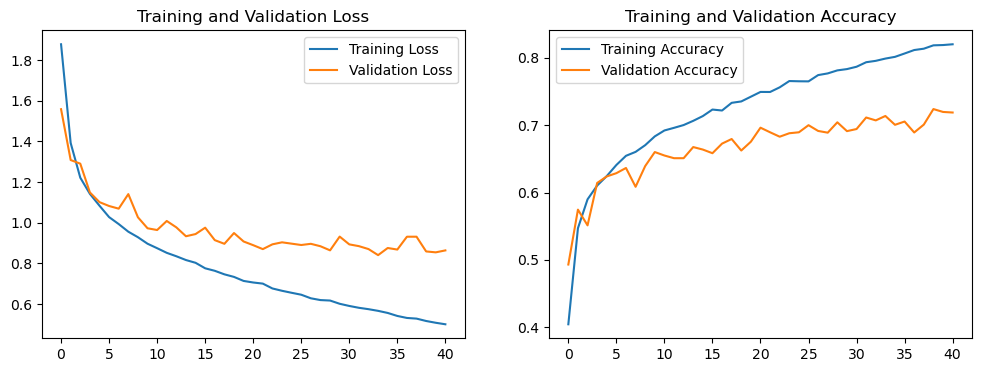

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Make predictions and calculate metrics
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate Precision, Recall, F1-Score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

print("\n")

# For a detailed classification report including precision, recall, f1-score per class
print(classification_report(y_test, predicted_classes))

110/110 [==============================] - 1s 6ms/step
Precision: 0.730956541176353, Recall: 0.7189281641961232, F1-Score: 0.7173981377458445


              precision    recall  f1-score   support

           0       0.87      0.75      0.80       212
           1       0.93      1.00      0.97       215
           2       0.76      0.47      0.58       224
           3       0.70      0.67      0.68       228
           4       0.67      0.68      0.68       216
           5       0.65      0.87      0.74       231
           6       0.71      0.67      0.69       230
           7       0.98      0.97      0.98       233
           8       0.75      0.70      0.73       218
           9       0.96      1.00      0.98       209
          10       0.46      0.45      0.46       209
          11       0.63      0.53      0.58       231
          12       0.63      0.51      0.56       247
          13       0.43      0.79      0.55       189
          14       0.59      0.51      0.55  